## 19-1. 프로젝트

In [2]:
import torch
import torchvision
import numpy as np
import PIL

print(torch.__version__)
print(torchvision.__version__)
print(np.__version__)
print(PIL.__version__)

1.9.1+cu111
0.10.1+cu111
1.21.4
8.3.2


In [20]:
import os
import numpy as np
from statistics import mean

import torch
import torchvision

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy import stats

from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [21]:
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='pastel',
              font='NanumBarunGothic',
              rc=custom_params)

### 1단계: Activation Vector 추출

In [4]:
# 경로 설정
PROJECT_PATH = os.getenv('HOME') + '/aiffel/socar_open_set'
MODEL_PATH = os.path.join(PROJECT_PATH, 'weights')
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
REJECT_PATH = os.path.join(DATA_PATH, 'reject')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# 데이터 전처리 파이프라인
def create_dataloader(path, batch_size, istrain):
    nearest_mode = torchvision.transforms.InterpolationMode.NEAREST
    normalize = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
    )
    train_transformer = torchvision.transforms.Compose([
        torchvision.transforms.Resize((320,320), interpolation=nearest_mode),
        torchvision.transforms.CenterCrop((224,224)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ColorJitter(),
        torchvision.transforms.ToTensor(),
        normalize
    ])

    test_transformer = torchvision.transforms.Compose([
        torchvision.transforms.Resize((320,320), interpolation=nearest_mode),
        torchvision.transforms.CenterCrop((224,224)),
        torchvision.transforms.ToTensor(),
        normalize
    ])
    
    if istrain:
        data = torchvision.datasets.ImageFolder(path, transform=train_transformer)
        dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        
    else:
        data = torchvision.datasets.ImageFolder(path, transform=test_transformer)
        dataloader = torch.utils.data.DataLoader(data, shuffle=False)

    return dataloader, data

In [7]:
# 학습 데이터를 연결하고, 미리 준비해 둔 모델을 불러오기
train_loader, _train_data = create_dataloader(TRAIN_PATH, 1, False)
target_class_num = len(os.listdir(TRAIN_PATH))

net = torchvision.models.resnet50(pretrained=True)
net.fc = torch.nn.Linear(
    net.fc.in_features,
    target_class_num
)

saved_weight_path = os.path.join(MODEL_PATH, 'classifier_acc_0.96008.pth')
net.load_state_dict(torch.load(saved_weight_path, map_location=device))
print('Successfully Loaded the Network Weight!')
net.eval()

net.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /aiffel/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Successfully Loaded the Network Weight!


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
train_preds = list()
train_actvecs = list()
train_outputs_softmax = list()
train_labels = list()

with torch.no_grad():
  for idx, (img, label) in enumerate(train_loader):
      img = img.to(device)
      label = label.to(device)

      out = net(img)
      out_actvec = out.cpu().detach().numpy()[0]
      out_softmax = torch.softmax(out, 1).cpu().detach().numpy()[0]
      out_pred = int(torch.argmax(out).cpu().detach().numpy())
      out_label = int(label.cpu().detach().numpy())

      train_actvecs.append(out_actvec) # component 1: softmax 전의 Activation Vector
      train_preds.append(out_pred) # componenet 2: 각 데이터에 대한 예측값
      train_outputs_softmax.append(out_softmax) # component 3: 각 데이터에 대한 softmax 확률
      train_labels.append(out_label) # component 4: 각 데이터에 대한 Label (정답)

train_actvecs = np.asarray(train_actvecs)
train_preds = np.asarray(train_preds)
train_outputs_softmax = np.asarray(train_outputs_softmax)
train_labels = np.asarray(train_labels)

In [9]:
train_correct_actvecs = train_actvecs[train_labels==train_preds]
train_correct_labels = train_labels[train_labels==train_preds]
print('Activation vector: ', train_correct_actvecs.shape)
print('Labels: ', train_correct_labels.shape)

Activation vector:  (4790, 4)
Labels:  (4790,)


### 2단계: Weibull-Distribution

In [11]:
# 베이불 분포의 모수를 얻기
class_means = list()
dist_to_means = list()
mr_models = {}

for class_idx in np.unique(train_labels):
    
    print('class_idx: ', class_idx)
    class_act_vec = train_correct_actvecs[train_correct_labels==class_idx]
    print(class_act_vec.shape)
    
    class_mean = class_act_vec.mean(axis=0)
    class_means.append(class_mean)
    
    dist_to_mean = np.square(class_act_vec - class_mean).sum(axis=1) # 각 activation vector의 거리를 계산
    dist_to_mean_sorted = np.sort(dist_to_mean).astype(np.float64) # 거리를 기준으로 오름차순 정렬
    dist_to_means.append(dist_to_mean_sorted)

    shape, loc, scale = stats.weibull_max.fit(dist_to_mean_sorted[-100:]) # 거리가 가장 먼 100개를 사용하여 모수 추출
    
    mr_models[str(class_idx)] = {
        'shape':shape,
        'loc':loc,
        'scale':scale
    }
    
class_means = np.asarray(class_means)

class_idx:  0
(1250, 4)
class_idx:  1
(1170, 4)
class_idx:  2
(1179, 4)
class_idx:  3
(1191, 4)


### OpenMax 적용

In [12]:
# reject 클래스 추가
def compute_openmax(actvec, class_means, mr_models):
    dist_to_mean = np.square(actvec - class_means).sum(axis=1)

    scores = list()
    for class_idx in range(len(class_means)):
        params = mr_models[str(class_idx)]
        score = stats.weibull_max.cdf(
            dist_to_mean[class_idx],
            params['shape'],
            params['loc'],
            params['scale']
        )
        scores.append(score)
    scores = np.asarray(scores)
    
    weight_on_actvec = 1 - scores # 각 class별 가중치
    rev_actvec = np.concatenate([
        weight_on_actvec * actvec, # known class에 대한 가중치 곱
        [((1-weight_on_actvec) * actvec).sum()] # unknown class에 새로운 계산식
    ])
    
    openmax_prob = np.exp(rev_actvec) / np.exp(rev_actvec).sum()
    return openmax_prob

In [13]:
def inference(actvec, threshold, target_class_num, class_means, mr_models):
    openmax_prob = compute_openmax(actvec, class_means, mr_models)
    openmax_softmax = np.exp(openmax_prob)/sum(np.exp(openmax_prob))

    pred = np.argmax(openmax_softmax)
    if np.max(openmax_softmax) < threshold:
        pred = target_class_num
    return pred

In [14]:
# Threshold 탐색을 쉽게 하기 위해 함수 설정
def inference_dataloader(net, data_loader, threshold, target_class_num, class_means, mr_models, is_reject=False):
    result_preds = list()
    result_labels = list()

    with torch.no_grad():
      for idx, (img, label) in enumerate(data_loader):
          img = img.to(device)
          label = label.to(device)

          out = net(img)
          out_actvec = out.cpu().detach().numpy()[0]
          out_softmax = torch.softmax(out, 1).cpu().detach().numpy()[0]
          out_label = int(label.cpu().detach().numpy())

          pred = inference(out_actvec, threshold, target_class_num, class_means, mr_models)
      
          result_preds.append(pred)
          if is_reject:
              result_labels.append(target_class_num)
          else:
              result_labels.append(out_label)

    return result_preds, result_labels

In [79]:
test_loader, _test_data = create_dataloader(TEST_PATH, 1, False)
reject_loader, _reject_data = create_dataloader(REJECT_PATH, 1, False)
target_class_num = len(os.listdir(TEST_PATH))

### 최적의 threshold 찾기

In [80]:
test_accuracy_dict = {} # 사전형으로 정확도들을 저장
reject_accuracy_dict = {}

# threshold 정확도 추출 과정 함수화
def thr(num):    
    test_preds, test_labels = inference_dataloader(net, test_loader, num, target_class_num, class_means, mr_models)
    reject_preds, reject_labels = inference_dataloader(net, reject_loader, num, target_class_num, class_means, mr_models, is_reject=True)
    
    test_accuracy_dict.update({f'{num}' : accuracy_score(test_labels, test_preds)}) # 사전형 저장
    reject_accuracy_dict.update({f'{num}' : accuracy_score(reject_labels, reject_preds)})

    print('Test Accuracy: ', accuracy_score(test_labels, test_preds))
    print('Reject Accuracy: ', accuracy_score(reject_labels, reject_preds))

In [81]:
th_list = [0.36, 0.37, 0.38, 0.39] # threshold값들 임의 지정 및 for문 활용
for i in th_list:
    thr(i)

Test Accuracy:  0.931
Reject Accuracy:  0.576
Test Accuracy:  0.916
Reject Accuracy:  0.64
Test Accuracy:  0.888
Reject Accuracy:  0.712
Test Accuracy:  0.81
Reject Accuracy:  0.746


In [82]:
# 사전형으로 저장한 값들 list토 변환
t_list = list(test_accuracy_dict.keys())
test_values_list = list(test_accuracy_dict.values())
reject_values_list = list(reject_accuracy_dict.values())

print(t_list)
print(values_list)
print(reject_values_list)

['0.36', '0.37', '0.38', '0.39']
[0.931, 0.916, 0.888, 0.81]
[0.576, 0.64, 0.712, 0.746]


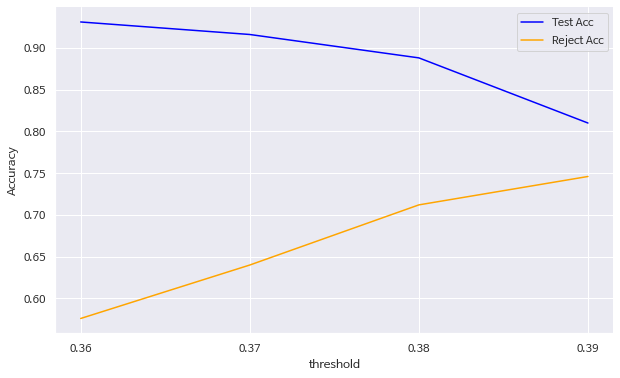

In [83]:
# 시각화
plt.figure(figsize=(10, 6))

sns.lineplot(x=t_list, y=test_values_list, color='blue', label='Test Acc')
sns.lineplot(x=t_list, y=reject_values_list, color='orange', label='Reject Acc')

plt.xlabel('threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

* Test Acc가 0.85이상이고, Reject Acc가 최대치인 부분을 찾으려면 0.38 ~ 0.39 에서 탐색필요

Test Accuracy:  0.887
Reject Accuracy:  0.719
Test Accuracy:  0.883
Reject Accuracy:  0.723
Test Accuracy:  0.876
Reject Accuracy:  0.724
Test Accuracy:  0.871
Reject Accuracy:  0.727
Test Accuracy:  0.865
Reject Accuracy:  0.73
Test Accuracy:  0.857
Reject Accuracy:  0.733
Test Accuracy:  0.846
Reject Accuracy:  0.735
Test Accuracy:  0.834
Reject Accuracy:  0.737
Test Accuracy:  0.96
Reject Accuracy:  0.046
Test Accuracy:  0.0
Reject Accuracy:  1.0
Test Accuracy:  0.81
Reject Accuracy:  0.746


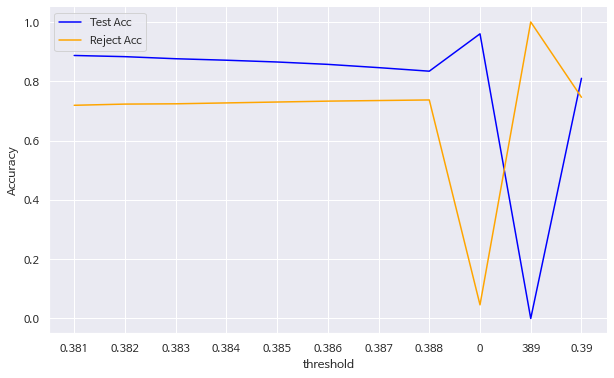

In [84]:
test_accuracy_dict = {} #사전형 초기화
reject_accuracy_dict = {}

th_list = [0.381, 0.382, 0.383, 0.384, 0.385, 0.386, 0.387, 0.388, 0,389, 0.390] # 범위의 세분화
for i in th_list:
        thr(i)

t_list = list(test_accuracy_dict.keys())
test_values_list = list(test_accuracy_dict.values())
reject_values_list = list(reject_accuracy_dict.values())

plt.figure(figsize=(10, 6))

sns.lineplot(x=t_list, y=test_values_list, color='blue', label='Test Acc')
sns.lineplot(x=t_list, y=reject_values_list, color='orange', label='Reject Acc')

plt.xlabel('threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [85]:
print(test_accuracy_dict)

{'0.381': 0.887, '0.382': 0.883, '0.383': 0.876, '0.384': 0.871, '0.385': 0.865, '0.386': 0.857, '0.387': 0.846, '0.388': 0.834, '0': 0.96, '389': 0.0, '0.39': 0.81}


* 0.386 ~ 0.387 구간에서 Test Acc가 0.85밑으로 떨어짐 해당 부분에서 다시 탐색
* 더이상 시각화를 통해 눈으로 확인하는것이 아닌 최대값을 활용해서 최댓값만 뽑아보기

In [86]:
# 범위의 세분화 arange활용
th_list = []
for i in np.arange(0.3861, 0.3869, 0.0001):
    th_list.append(round(i, 4))
print(th_list)

[0.3861, 0.3862, 0.3863, 0.3864, 0.3865, 0.3866, 0.3867, 0.3868, 0.3869]


In [72]:
max_acc = ['0.3', 0, 0]

def max_thr(num):
    test_preds, test_labels = inference_dataloader(net, test_loader, num, target_class_num, class_means, mr_models)
    reject_preds, reject_labels = inference_dataloader(net, reject_loader, num, target_class_num, class_means, mr_models, is_reject=True)
    
    # Test Acc가 0.85보다 높고 Reject Acc가 기존의 값보다 높을때 max_acc 업데이트
    if accuracy_score(test_labels, test_preds) >= 0.85 and accuracy_score(reject_labels, reject_preds) > max_acc[2]:
        max_acc.clear()
        max_acc.extend([f'{num}', accuracy_score(test_labels, test_preds), accuracy_score(reject_labels, reject_preds)])

In [73]:
for i in th_list:
    max_thr(i)

In [75]:
print(max_acc)

['0.3865', 0.852, 0.734]


* threshold 탐색 과정을 거친후 최적의 값은 '0.3865'
* 해당 값의 Testaccuracy는 0.852, Rejectaccuracy는 0.734

## 회고
##### 작성자 : 김영준

---
### 평가문항
1. 쏘카 데이터를 이용하여 각자 모델을 학습시키고 OpenMax를 적용해 본다.
 * 쏘카 데이터를 활용하여 OpenMax 적용에 성공했다.
2. Test accuracy 0.85 이상이고, reject accuracy가 최대가 되도록 만드는 threshold를 찾는다.
 * 조건을 만족하는 threshold를 찾았다.
3. Threshold 변화에 따른 test accuracy와 reject accuracy의 추이를 비교 분석한다.
* Test accuracy와 reject accuracy의 변화를 타당하고 체계적으로 분석하였다.

### 총평
* OpenMax에서 적용하는 Reject개념이 매우 흥미로웠음
* OpenMax를 구성하는 과정에서 사용되는 함수들에 대한 추가적인 공부가 필요함
* 현재 이 모델은 하나의 threshold값마다 훈련에 소모되는 시간이 상당히 오래걸림
* 해당 시간을 줄이기 위해 개선된 모델을 따로 찾아봐야 할 필요성이 있음
* threshold의 최적값을 찾는방법을 주먹구구식으로 해결하였으나 좀더 체계적인 방법이 있을것으로 예상
* 이전까지는 함수를 직접 정의하고 사용하는것이 익숙하지 않았으나 스스로 정의하면서 사용해보니 매우 편리함
* 임의의 함수 정의를 앞으로 적극 활용하겠음